In [ ]:
!pip install seaborn -q

In [1]:
!pip install datasets -q

In [1]:
import os
print(os.getpid())

2257117


In [2]:
import pandas as pd
import numpy as np

LABEL = 'mistake_identification'
MODEL = "roberta-large"
train_df = pd.read_csv("data/mistake_identification_train.csv")
val_df = pd.read_csv("data/mistake_identification_val.csv")

full_df = pd.concat([train_df, val_df]).reset_index(drop=True)

In [3]:
import torch, random, numpy as np

SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [4]:
from collections import Counter

def get_weights(train_df, label, normalized=False):
  label_counts = Counter(train_df[label])
  total = sum(label_counts.values())
  weights = torch.tensor([total / label_counts.get(cls, 1) for cls in range(3)])
  if normalized:
    weights_normalized = weights / weights.mean()
    return weights_normalized
  return weights

In [5]:
alpha_equal = torch.tensor([1.0, 1.0, 1.0])
weights = get_weights(train_df, LABEL)
weights_normalized = get_weights(train_df, LABEL, True)

In [6]:
print(alpha_equal)
print(weights)
print(weights_normalized)

tensor([1., 1., 1.])
tensor([ 6.6768, 13.8671,  1.2852])
tensor([0.9176, 1.9058, 0.1766])


In [7]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=-1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            at = self.alpha.to(targets.device).gather(0, targets)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [8]:
from torch.utils.data import Sampler
import numpy as np
from collections import defaultdict
import random

class StratifiedBatchSampler(Sampler):
    def __init__(self, labels, batch_size, shuffle=True):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_to_indices = defaultdict(list)

        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

    def __iter__(self):
        all_batches = []

        # Stratify each batch
        min_class_count = min([len(v) for v in self.label_to_indices.values()])
        n_batches = len(self.labels) // self.batch_size

        # Estimate proportions
        proportions = {
            k: len(v) / len(self.labels)
            for k, v in self.label_to_indices.items()
        }

        for _ in range(n_batches):
            batch = []
            for cls, prob in proportions.items():
                n_cls = max(1, int(prob * self.batch_size))
                chosen = random.sample(self.label_to_indices[cls], min(n_cls, len(self.label_to_indices[cls])))
                batch.extend(chosen)
            if self.shuffle:
                random.shuffle(batch)
            all_batches.append(batch[:self.batch_size])

        random.shuffle(all_batches)
        return iter([i for batch in all_batches for i in batch])

    def __len__(self):
        return len(self.labels)


In [9]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="cross_entropy", **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.weights = weights
        self.focal_loss = FocalLoss(alpha=alpha if loss_type == "focal" else None)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
      labels = inputs.pop("labels")
      outputs = model(**inputs)
      logits = outputs.logits

      if self.loss_type == "focal":
          loss = self.focal_loss(logits, labels)
      elif self.loss_type == "weighted":
          w = self.weights.to(logits.device)
          loss = F.cross_entropy(logits, labels, weight=w)
      else:
          loss = F.cross_entropy(logits, labels)

      return (loss, outputs) if return_outputs else loss

    # Allows stratified batches - comment out if you don t want stratified batches
    # def get_train_dataloader(self):
    #     if self.train_dataset is None:
    #         raise ValueError("Trainer: training requires a train_dataset.")

    #     # Extract labels from dataset
    #     labels = self.train_dataset['labels']

    #     sampler = StratifiedBatchSampler(
    #         labels=labels,
    #         batch_size=self.args.train_batch_size,
    #         shuffle=True
    #     )

    #     return DataLoader(
    #         self.train_dataset,
    #         batch_size=self.args.train_batch_size,
    #         sampler=sampler,
    #         collate_fn=self.data_collator,
    #         drop_last=self.args.dataloader_drop_last,
    #         num_workers=self.args.dataloader_num_workers,
    #     )


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
TODO: adjust max_length based on 95th percentile for each case

TODO: prompt engineering

SyntaxError: invalid decimal literal (1456326944.py, line 1)

In [13]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL)
def tokenize(batch, use_context=True):
    if use_context:
        text1 = [f"Student: {x}" for x in batch['last_student_turn']]
        text2 = [f"Tutor: {x}" for x in batch['response']]
        return tokenizer(text1, text2, truncation=True, padding="max_length", max_length=512)
    else:
        text = [x for x in batch['response']]
        return tokenizer(text, truncation=True, padding="max_length", max_length=512)

from functools import partial
tokenize_with_context = partial(tokenize, use_context=True)
tokenize_no_context = partial(tokenize, use_context=False)

In [14]:
from datasets import Dataset

train_ds_context = Dataset.from_pandas(train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
val_ds_context = Dataset.from_pandas(val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))

train_ds_context = train_ds_context.map(tokenize_with_context, batched=True)
val_ds_context = val_ds_context.map(tokenize_with_context, batched=True)

train_ds_nocontext = Dataset.from_pandas(train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
val_ds_nocontext = Dataset.from_pandas(val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))

train_ds_nocontext = train_ds_nocontext.map(tokenize_no_context, batched=True)
val_ds_nocontext = val_ds_nocontext.map(tokenize_no_context, batched=True)

Map: 100% 1983/1983 [00:00<00:00, 4912.84 examples/s]
Map: 100% 493/493 [00:00<00:00, 4655.66 examples/s]
Map: 100% 1983/1983 [00:00<00:00, 6145.22 examples/s]
Map: 100% 493/493 [00:00<00:00, 6048.74 examples/s]


In [17]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix
# Metrics
def compute_lenient_metrics(y_true, y_pred):
    def to_lenient(y): return np.where(np.isin(y, [1, 2]), 1, 0)
    y_true_len = to_lenient(y_true)
    y_pred_len = to_lenient(y_pred)

    acc = balanced_accuracy_score(y_true_len, y_pred_len)
    f1 = f1_score(y_true_len, y_pred_len, average="binary")
    return acc, f1


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    macro_f1 = f1_score(labels, preds, average="macro")
    acc = balanced_accuracy_score(labels, preds)
    len_acc, len_f1 = compute_lenient_metrics(labels, preds)
    conf = confusion_matrix(labels, preds)

    print("Confusion Matrix:")
    print(conf)
    # print(classification_report(labels, preds, target_names=["No", "TSE", "Yes"]))


    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "lenient_accuracy": len_acc,
        "lenient_f1": len_f1
    }

In [18]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# Model
model = RobertaForSequenceClassification.from_pretrained(MODEL, num_labels=3)

# Training
args = TrainingArguments(
    output_dir="./outputs_mistake_id_roberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,                     # recommended for RoBERTa-large
    per_device_train_batch_size=8,          # reduce if OOM
    per_device_eval_batch_size=8,
    num_train_epochs=4,                     
    warmup_ratio=0.1,                       # important for RoBERTa stability
    weight_decay=0.01,
    logging_dir="./logs_roberta",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=2,
    lr_scheduler_type="linear",             # linear or cosine both work well
    fp16=torch.cuda.is_available(),         
    gradient_checkpointing=True,            # helps reduce memory
    report_to="none",                       # or "tensorboard"/"wandb" if needed
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import torch, numpy as np, random
from transformers import RobertaForSequenceClassification
from collections import defaultdict
import pandas as pd

results = []

seeds = [42, 52, 62, 88, 99]
contexts = [True, False]

for use_context in contexts:
    for seed in seeds:
        print(f"\n==== Running: context={use_context}, seed={seed} ====")

        # Fix seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Tokenize
        train_ds = train_ds_context if use_context else train_ds_nocontext
        val_ds = val_ds_context if use_context else val_ds_nocontext

        # Define trainer
        model = RobertaForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        )

        trainer.train()
        metrics = trainer.evaluate()

        # Save results
        results.append({
        "context": use_context,
        "seed": seed,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
      })


# Create result DataFrame
df_context = pd.DataFrame(results)
df_context.to_csv("results_context_comparison.csv", index=False)
print("\n All experiments complete. Results saved to 'results_context_comparison.csv'.")




==== Running: context=True, seed=42 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
df_context

,context,seed,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,True,42,0.555945,0.700287,0.965842,0.894523,0.941176
1,True,52,0.536447,0.687964,0.963572,0.888438,0.937120
2,True,62,0.593741,0.675755,0.962175,0.886410,0.935091
3,True,88,0.558683,0.673045,0.962264,0.882353,0.935091
4,True,99,0.520346,0.676742,0.965842,0.894523,0.941176
5,False,42,0.532795,0.629411,0.961039,0.876268,0.933063
6,False,52,0.521937,0.686720,0.962264,0.886410,0.935091
7,False,62,0.489638,0.649745,0.963400,0.882353,0.937120
8,False,88,0.546296,0.629348,0.956419,0.868154,0.924949
9,False,99,0.515535,0.730862,0.965922,0.888438,0.941176


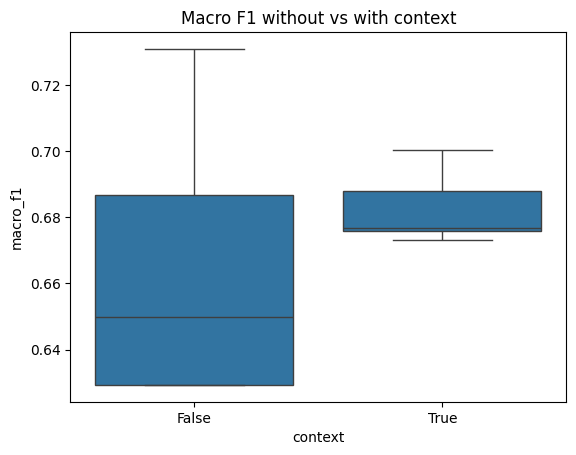

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

df_context = pd.read_csv("results_context_comparison.csv")
sns.boxplot(data=df_context, x="context", y="macro_f1")
plt.title("Macro F1 without vs with context")
plt.show()

In [ ]:
Roberta large performs better with context, across all metrics and seeds. E un outlier in care pt no context am obt 0.73.

In [28]:
alpha = alpha_equal
alpha

tensor([1., 1., 1.])

In [25]:
weights = weights_normalized
weights

tensor([0.9176, 1.9058, 0.1766])

In [ ]:
*Din punctul asta am folosit balanced_accuracy_score 

In [31]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

results = []

seeds = [42, 52, 62, 88, 99]
loss_types = ["weighted", "focal"]

for loss_type in loss_types:
    for seed in seeds:
        print(f"\n==== Running: loss_type={loss_type}, seed={seed} ====")

        # Fix seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Define trainer
        model = RobertaForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds_context, # ALWAYS USING CONTEXT FROM NOW ON
            eval_dataset=val_ds_context,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type=loss_type
        )

        trainer.train()
        metrics = trainer.evaluate()

        # Save results
        results.append({
        "loss_type": loss_type,
        "seed": seed,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
      })


# Create result DataFrame
df_loss = pd.DataFrame(results)
df_loss.to_csv("results_loss_comparison.csv", index=False)


==== Running: loss_type=weighted, seed=42 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.956100,0.863100,0.599328,0.611783,0.745385,0.956621
2,0.853500,0.812704,0.655930,0.670476,0.821037,0.951479
3,0.652200,1.086142,0.610736,0.639130,0.822228,0.952719
4,0.545900,1.097463,0.622627,0.643561,0.830267,0.955083


Confusion Matrix:
[[ 36  12  25]
 [  1  12  18]
 [  0  32 357]]
              precision    recall  f1-score   support

          No       0.97      0.49      0.65        73
         TSE       0.21      0.39      0.28        31
         Yes       0.89      0.92      0.90       389

    accuracy                           0.82       493
   macro avg       0.69      0.60      0.61       493
weighted avg       0.86      0.82      0.83       493

Confusion Matrix:
[[ 50   3  20]
 [  2  11  18]
 [ 16  12 361]]
              precision    recall  f1-score   support

          No       0.74      0.68      0.71        73
         TSE       0.42      0.35      0.39        31
         Yes       0.90      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.69      0.66      0.67       493
weighted avg       0.85      0.86      0.85       493

Confusion Matrix:
[[ 50   1  22]
 [  4   6  21]
 [ 13   5 371]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   3  20]
 [  2  11  18]
 [ 16  12 361]]
              precision    recall  f1-score   support

          No       0.74      0.68      0.71        73
         TSE       0.42      0.35      0.39        31
         Yes       0.90      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.69      0.66      0.67       493
weighted avg       0.85      0.86      0.85       493


==== Running: loss_type=weighted, seed=52 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.992200,1.009137,0.487043,0.248118,0.791895,0.879487
2,0.917700,0.790177,0.648218,0.649780,0.831751,0.962529
3,0.689400,1.020149,0.643181,0.673490,0.853196,0.960947
4,0.657000,1.159253,0.639472,0.674565,0.852299,0.965922


Confusion Matrix:
[[ 56  17   0]
 [ 11  20   0]
 [ 66 304  19]]
              precision    recall  f1-score   support

          No       0.42      0.77      0.54        73
         TSE       0.06      0.65      0.11        31
         Yes       1.00      0.05      0.09       389

    accuracy                           0.19       493
   macro avg       0.49      0.49      0.25       493
weighted avg       0.86      0.19      0.16       493

Confusion Matrix:
[[ 50   6  17]
 [  1  11  19]
 [  8  29 352]]
              precision    recall  f1-score   support

          No       0.85      0.68      0.76        73
         TSE       0.24      0.35      0.29        31
         Yes       0.91      0.90      0.91       389

    accuracy                           0.84       493
   macro avg       0.66      0.65      0.65       493
weighted avg       0.86      0.84      0.85       493

Confusion Matrix:
[[ 54   2  17]
 [  4   7  20]
 [ 10   4 375]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   2  18]
 [  2   7  22]
 [  7   6 376]]
              precision    recall  f1-score   support

          No       0.85      0.73      0.79        73
         TSE       0.47      0.23      0.30        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.64      0.67       493
weighted avg       0.87      0.88      0.87       493


==== Running: loss_type=weighted, seed=62 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.966300,0.862820,0.573623,0.443360,0.784736,0.898876
2,0.879300,0.794252,0.631091,0.639261,0.834736,0.953737
3,0.618200,0.968951,0.630139,0.646597,0.849331,0.950898
4,0.554200,1.062273,0.669241,0.672352,0.865117,0.949275


Confusion Matrix:
[[ 52   7  14]
 [  6  17   8]
 [ 54 156 179]]
              precision    recall  f1-score   support

          No       0.46      0.71      0.56        73
         TSE       0.09      0.55      0.16        31
         Yes       0.89      0.46      0.61       389

    accuracy                           0.50       493
   macro avg       0.48      0.57      0.44       493
weighted avg       0.78      0.50      0.57       493

Confusion Matrix:
[[ 52   2  19]
 [  5   8  18]
 [ 13  17 359]]
              precision    recall  f1-score   support

          No       0.74      0.71      0.73        73
         TSE       0.30      0.26      0.28        31
         Yes       0.91      0.92      0.91       389

    accuracy                           0.85       493
   macro avg       0.65      0.63      0.64       493
weighted avg       0.84      0.85      0.85       493

Confusion Matrix:
[[ 55   1  17]
 [  5   6  20]
 [ 18   4 367]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 58   1  14]
 [  6   9  16]
 [ 21   9 359]]
              precision    recall  f1-score   support

          No       0.68      0.79      0.73        73
         TSE       0.47      0.29      0.36        31
         Yes       0.92      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.69      0.67      0.67       493
weighted avg       0.86      0.86      0.86       493


==== Running: loss_type=weighted, seed=88 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,1.038100,0.872271,0.633761,0.480495,0.807942,0.937650
2,0.869500,0.844411,0.662785,0.689547,0.832942,0.963743
3,0.659600,0.956117,0.630621,0.659630,0.839498,0.958678
4,0.544700,1.159820,0.654215,0.678774,0.861236,0.963314


Confusion Matrix:
[[ 50  12  11]
 [  4  24   3]
 [ 25 192 172]]
              precision    recall  f1-score   support

          No       0.63      0.68      0.66        73
         TSE       0.11      0.77      0.19        31
         Yes       0.92      0.44      0.60       389

    accuracy                           0.50       493
   macro avg       0.55      0.63      0.48       493
weighted avg       0.83      0.50      0.58       493

Confusion Matrix:
[[ 50   3  20]
 [  1  11  19]
 [  7  13 369]]
              precision    recall  f1-score   support

          No       0.86      0.68      0.76        73
         TSE       0.41      0.35      0.38        31
         Yes       0.90      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.66      0.69       493
weighted avg       0.87      0.87      0.87       493

Confusion Matrix:
[[ 52   2  19]
 [  2   7  22]
 [ 12   6 371]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   3  20]
 [  1  11  19]
 [  7  13 369]]
              precision    recall  f1-score   support

          No       0.86      0.68      0.76        73
         TSE       0.41      0.35      0.38        31
         Yes       0.90      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.66      0.69       493
weighted avg       0.87      0.87      0.87       493


==== Running: loss_type=weighted, seed=99 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.896000,0.893195,0.532919,0.315224,0.817759,0.954064
2,0.858200,0.846857,0.689609,0.679166,0.835926,0.954976
3,0.637200,1.006604,0.612261,0.649052,0.837410,0.962441
4,0.587100,1.137059,0.645846,0.673262,0.831458,0.956316


Confusion Matrix:
[[ 49  24   0]
 [  4  27   0]
 [ 11 356  22]]
              precision    recall  f1-score   support

          No       0.77      0.67      0.72        73
         TSE       0.07      0.87      0.12        31
         Yes       1.00      0.06      0.11       389

    accuracy                           0.20       493
   macro avg       0.61      0.53      0.32       493
weighted avg       0.91      0.20      0.20       493

Confusion Matrix:
[[ 52   4  17]
 [  2  14  15]
 [ 15  22 352]]
              precision    recall  f1-score   support

          No       0.75      0.71      0.73        73
         TSE       0.35      0.45      0.39        31
         Yes       0.92      0.90      0.91       389

    accuracy                           0.85       493
   macro avg       0.67      0.69      0.68       493
weighted avg       0.86      0.85      0.85       493

Confusion Matrix:
[[ 51   2  20]
 [  3   5  23]
 [  7   2 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   4  17]
 [  2  14  15]
 [ 15  22 352]]
              precision    recall  f1-score   support

          No       0.75      0.71      0.73        73
         TSE       0.35      0.45      0.39        31
         Yes       0.92      0.90      0.91       389

    accuracy                           0.85       493
   macro avg       0.67      0.69      0.68       493
weighted avg       0.86      0.85      0.85       493


==== Running: loss_type=focal, seed=42 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.256900,0.171431,0.557654,0.601749,0.789759,0.960739
2,0.196300,0.228092,0.558511,0.600953,0.788568,0.959538
3,0.193500,0.214397,0.599888,0.623948,0.849918,0.963486
4,0.118500,0.241446,0.644519,0.691545,0.839791,0.964871


Confusion Matrix:
[[ 43   1  29]
 [  1   3  27]
 [  3   2 384]]
              precision    recall  f1-score   support

          No       0.91      0.59      0.72        73
         TSE       0.50      0.10      0.16        31
         Yes       0.87      0.99      0.93       389

    accuracy                           0.87       493
   macro avg       0.76      0.56      0.60       493
weighted avg       0.86      0.87      0.85       493

Confusion Matrix:
[[ 43   2  28]
 [  2   3  26]
 [  3   1 385]]
              precision    recall  f1-score   support

          No       0.90      0.59      0.71        73
         TSE       0.50      0.10      0.16        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.87       493
   macro avg       0.76      0.56      0.60       493
weighted avg       0.86      0.87      0.85       493

Confusion Matrix:
[[ 53   1  19]
 [  4   3  24]
 [  7   2 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  2   8  21]
 [  6   3 380]]
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        73
         TSE       0.62      0.26      0.36        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.79      0.64      0.69       493
weighted avg       0.88      0.89      0.88       493


==== Running: loss_type=focal, seed=52 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.238200,0.174165,0.563452,0.593193,0.813584,0.961583
2,0.208400,0.211765,0.578302,0.632976,0.790949,0.961938
3,0.196800,0.245319,0.612637,0.637264,0.850815,0.958482
4,0.098000,0.246164,0.636619,0.675118,0.844260,0.963572


Confusion Matrix:
[[ 47   1  25]
 [  2   2  27]
 [  5   2 382]]
              precision    recall  f1-score   support

          No       0.87      0.64      0.74        73
         TSE       0.40      0.06      0.11        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.56      0.59       493
weighted avg       0.85      0.87      0.85       493

Confusion Matrix:
[[ 43   1  29]
 [  0   5  26]
 [  3   3 383]]
              precision    recall  f1-score   support

          No       0.93      0.59      0.72        73
         TSE       0.56      0.16      0.25        31
         Yes       0.87      0.98      0.93       389

    accuracy                           0.87       493
   macro avg       0.79      0.58      0.63       493
weighted avg       0.86      0.87      0.85       493

Confusion Matrix:
[[ 54   0  19]
 [  5   4  22]
 [ 11   1 377]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   7  21]
 [  7   4 378]]
              precision    recall  f1-score   support

          No       0.84      0.71      0.77        73
         TSE       0.54      0.23      0.32        31
         Yes       0.90      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.76      0.64      0.68       493
weighted avg       0.87      0.89      0.87       493


==== Running: loss_type=focal, seed=62 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.221900,0.182241,0.531958,0.543377,0.796314,0.955711
2,0.220100,0.205485,0.594947,0.638638,0.830855,0.967442
3,0.186900,0.236281,0.600652,0.634325,0.836220,0.961222
4,0.106200,0.255305,0.650224,0.689710,0.851109,0.964706


Confusion Matrix:
[[ 45   3  25]
 [  4   0  27]
 [  6   2 381]]
              precision    recall  f1-score   support

          No       0.82      0.62      0.70        73
         TSE       0.00      0.00      0.00        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.86       493
   macro avg       0.57      0.53      0.54       493
weighted avg       0.82      0.86      0.84       493

Confusion Matrix:
[[ 49   1  23]
 [  1   4  26]
 [  3   3 383]]
              precision    recall  f1-score   support

          No       0.92      0.67      0.78        73
         TSE       0.50      0.13      0.21        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.77      0.59      0.64       493
weighted avg       0.87      0.88      0.86       493

Confusion Matrix:
[[ 51   0  22]
 [  3   4  24]
 [  8   2 379]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   1  19]
 [  2   8  21]
 [  8   5 376]]
              precision    recall  f1-score   support

          No       0.84      0.73      0.78        73
         TSE       0.57      0.26      0.36        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.89       493
   macro avg       0.77      0.65      0.69       493
weighted avg       0.87      0.89      0.87       493


==== Running: loss_type=focal, seed=88 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.249700,0.213068,0.591039,0.605436,0.792156,0.939358
2,0.216000,0.227770,0.627593,0.686596,0.800179,0.965438
3,0.182500,0.228539,0.606838,0.643255,0.829371,0.960094
4,0.087300,0.250489,0.650224,0.685267,0.847538,0.961039


Confusion Matrix:
[[ 47   3  23]
 [  8   6  17]
 [ 17   8 364]]
              precision    recall  f1-score   support

          No       0.65      0.64      0.65        73
         TSE       0.35      0.19      0.25        31
         Yes       0.90      0.94      0.92       389

    accuracy                           0.85       493
   macro avg       0.64      0.59      0.61       493
weighted avg       0.83      0.85      0.84       493

Confusion Matrix:
[[ 44   4  25]
 [  1   9  21]
 [  0   4 385]]
              precision    recall  f1-score   support

          No       0.98      0.60      0.75        73
         TSE       0.53      0.29      0.38        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.80      0.63      0.69       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 50   2  21]
 [  3   5  23]
 [  8   2 379]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 44   4  25]
 [  1   9  21]
 [  0   4 385]]
              precision    recall  f1-score   support

          No       0.98      0.60      0.75        73
         TSE       0.53      0.29      0.38        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.80      0.63      0.69       493
weighted avg       0.88      0.89      0.87       493


==== Running: loss_type=focal, seed=99 ====


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.232400,0.186963,0.528823,0.553686,0.793330,0.964327
2,0.217200,0.228318,0.620832,0.672118,0.811497,0.965278
3,0.209800,0.236786,0.624434,0.648902,0.843966,0.957346
4,0.116200,0.243520,0.655554,0.693894,0.843069,0.962353


Confusion Matrix:
[[ 43   0  30]
 [  0   0  31]
 [  1   0 388]]
              precision    recall  f1-score   support

          No       0.98      0.59      0.74        73
         TSE       0.00      0.00      0.00        31
         Yes       0.86      1.00      0.93       389

    accuracy                           0.87       493
   macro avg       0.61      0.53      0.55       493
weighted avg       0.83      0.87      0.84       493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[ 46   2  25]
 [  0   8  23]
 [  3   7 379]]
              precision    recall  f1-score   support

          No       0.94      0.63      0.75        73
         TSE       0.47      0.26      0.33        31
         Yes       0.89      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.77      0.62      0.67       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 53   2  18]
 [  3   6  22]
 [ 13   5 371]]
              precision    recall  f1-score   support

          No       0.77      0.73      0.75        73
         TSE       0.46      0.19      0.27        31
         Yes       0.90      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.71      0.62      0.65       493
weighted avg       0.86      0.87      0.86       493

Confusion Matrix:
[[ 52   2  19]
 [  2   9  20]
 [  9   5 375]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  2   9  20]
 [  9   5 375]]
              precision    recall  f1-score   support

          No       0.83      0.71      0.76        73
         TSE       0.56      0.29      0.38        31
         Yes       0.91      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.66      0.69       493
weighted avg       0.87      0.88      0.87       493



In [32]:
df_loss

,loss_type,seed,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,weighted,42,0.812704,0.670476,0.951479,0.655930,0.821037
1,weighted,52,1.159253,0.674565,0.965922,0.639472,0.852299
2,weighted,62,1.062273,0.672352,0.949275,0.669241,0.865117
3,weighted,88,0.844411,0.689547,0.963743,0.662785,0.832942
4,weighted,99,0.846857,0.679166,0.954976,0.689609,0.835926
5,focal,42,0.241446,0.691545,0.964871,0.644519,0.839791
6,focal,52,0.246164,0.675118,0.963572,0.636619,0.844260
7,focal,62,0.255305,0.689710,0.964706,0.650224,0.851109
8,focal,88,0.227770,0.686596,0.965438,0.627593,0.800179
9,focal,99,0.243520,0.693894,0.962353,0.655554,0.843069


In [38]:
# Filter only context == False rows
df_ce = df_context[df_context["context"] == True].copy()
df_ce["loss_type"] = "ce"
df_ce = df_ce[["loss_type", "seed", "loss", "macro_f1", "lenient_f1", "accuracy", "lenient_accuracy"]]
df_loss = pd.concat([df_loss, df_ce], ignore_index=True)
df_loss

,loss_type,seed,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,weighted,42,0.812704,0.670476,0.951479,0.655930,0.821037
1,weighted,52,1.159253,0.674565,0.965922,0.639472,0.852299
2,weighted,62,1.062273,0.672352,0.949275,0.669241,0.865117
3,weighted,88,0.844411,0.689547,0.963743,0.662785,0.832942
4,weighted,99,0.846857,0.679166,0.954976,0.689609,0.835926
5,focal,42,0.241446,0.691545,0.964871,0.644519,0.839791
6,focal,52,0.246164,0.675118,0.963572,0.636619,0.844260
7,focal,62,0.255305,0.689710,0.964706,0.650224,0.851109
8,focal,88,0.227770,0.686596,0.965438,0.627593,0.800179
9,focal,99,0.243520,0.693894,0.962353,0.655554,0.843069


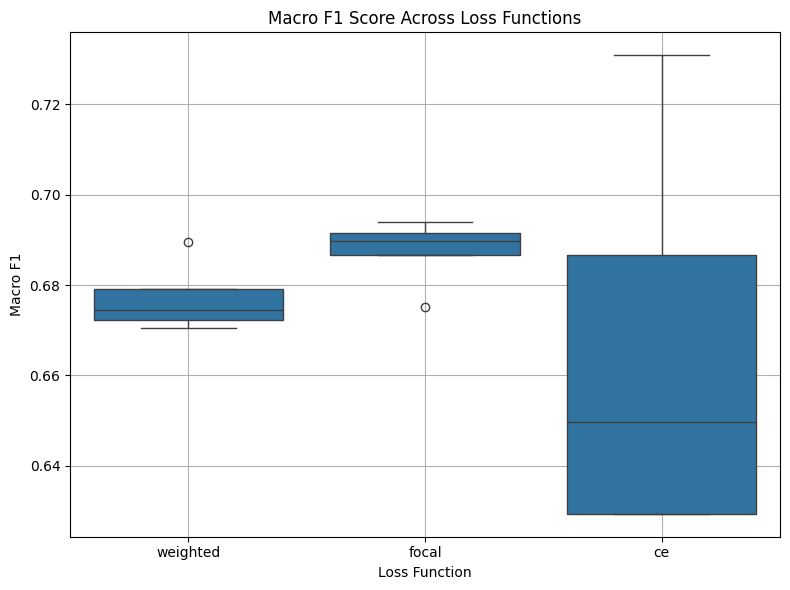

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_loss, x="loss_type", y="macro_f1")
plt.title("Macro F1 Score Across Loss Functions")
plt.ylabel("Macro F1")
plt.xlabel("Loss Function")
plt.grid(True)
plt.tight_layout()
plt.show()

Summary:
Context is the best for roberta-large.
Focal loss is the best for roberta-large.

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log
from collections import Counter
from transformers import AutoModelForSequenceClassification

samples_per_cls = [Counter(train_df[LABEL])[i] for i in range(3)]

class CBFocalLoss(nn.Module):
    """
    Class‑Balanced Focal Loss
        - beta controls how aggressively rare classes are up‑weighted
        - gamma is the focal‐loss focusing parameter
    """
    def __init__(self, samples_per_cls, beta=0.99, gamma=2.0, reduction='mean'):
        super().__init__()
        n_cls = len(samples_per_cls)

        effective_num = 1.0 - torch.pow(torch.tensor(beta), torch.tensor(samples_per_cls))
        self.weights = ((1.0 - beta) / effective_num).float()          
        self.weights = self.weights / self.weights.sum() * n_cls       # re‑normalise
        self.gamma   = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        logpt = F.log_softmax(logits, dim=-1)          # log‑prob for every class
        pt    = torch.exp(logpt)                       # prob for every class

        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt    = pt.gather(1, targets.unsqueeze(1)).squeeze(1)

        alpha_t = self.weights.to(logits.device).gather(0, targets)
        loss = -alpha_t * (1 - pt) ** self.gamma * logpt

        return loss.mean() if self.reduction == 'mean' else loss.sum()


class CBTrainer(CustomTrainer):
    def __init__(self, *args, beta=0.99, gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.cb_loss = CBFocalLoss(samples_per_cls,
                                   beta=beta, gamma=gamma)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss    = self.cb_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


beta_grid  = [0.9, 0.99]
gamma_grid = [1.0, 2.0]
seeds      = [42, 52, 62, 88, 99]

cb_results = []

for beta in beta_grid:
    for gamma in gamma_grid:
        for seed in seeds:
            print(f"\n=== CB‑Focal: beta={beta}, gamma={gamma}, seed={seed} ===")

            # reproducibility
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            np.random.seed(seed)
            random.seed(seed)

            model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

            trainer = CBTrainer(
                model=model,
                args=args,
                train_dataset=train_ds_nocontext,      # response‑only proved strongest
                eval_dataset=val_ds_nocontext,
                compute_metrics=compute_metrics,
                beta=beta,
                gamma=gamma,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            trainer.train()
            metrics = trainer.evaluate()

            cb_results.append({
                "beta": beta,
                "gamma": gamma,
                "seed": seed,
                "loss": metrics.get("eval_loss", -1),
                "macro_f1": metrics.get("eval_macro_f1", -1),
                "lenient_f1": metrics.get("eval_lenient_f1", -1),
                "accuracy": metrics.get("eval_accuracy", -1),
                "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
            })

df_cb = pd.DataFrame(cb_results)
df_cb.to_csv("results_cb_focal.csv", index=False)
display(df_cb.groupby(["beta", "gamma"]).agg({"macro_f1":"mean"}).sort_values("macro_f1", ascending=False))


=== CB‑Focal: beta=0.9, gamma=1.0, seed=42 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.332100,0.270674,0.577539,0.624311,0.801076,0.960557
2,0.298700,0.320377,0.598281,0.649943,0.818346,0.966396
3,0.294600,0.317439,0.605500,0.629862,0.843966,0.957346
4,0.178100,0.328679,0.628719,0.663761,0.849918,0.963486


Confusion Matrix:
[[ 45   1  27]
 [  2   4  25]
 [  4   1 384]]
              precision    recall  f1-score   support

          No       0.88      0.62      0.73        73
         TSE       0.67      0.13      0.22        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.88       493
   macro avg       0.81      0.58      0.62       493
weighted avg       0.87      0.88      0.86       493

Confusion Matrix:
[[ 47   2  24]
 [  1   5  25]
 [  2   2 385]]
              precision    recall  f1-score   support

          No       0.94      0.64      0.76        73
         TSE       0.56      0.16      0.25        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.79      0.60      0.65       493
weighted avg       0.87      0.89      0.87       493

Confusion Matrix:
[[ 53   1  19]
 [  2   4  25]
 [ 14   1 374]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   1  19]
 [  2   6  23]
 [  9   4 376]]
              precision    recall  f1-score   support

          No       0.83      0.73      0.77        73
         TSE       0.55      0.19      0.29        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.63      0.66       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.9, gamma=1.0, seed=52 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.304400,0.289911,0.562597,0.591107,0.768624,0.945029
2,0.304800,0.313896,0.592095,0.641248,0.825196,0.967517
3,0.273300,0.300970,0.588761,0.622978,0.832942,0.963743
4,0.189500,0.328855,0.608070,0.633761,0.848728,0.962264


Confusion Matrix:
[[ 42   4  27]
 [  3   5  23]
 [ 13   6 370]]
              precision    recall  f1-score   support

          No       0.72      0.58      0.64        73
         TSE       0.33      0.16      0.22        31
         Yes       0.88      0.95      0.91       389

    accuracy                           0.85       493
   macro avg       0.65      0.56      0.59       493
weighted avg       0.82      0.85      0.83       493

Confusion Matrix:
[[ 48   1  24]
 [  0   4  27]
 [  3   1 385]]
              precision    recall  f1-score   support

          No       0.94      0.66      0.77        73
         TSE       0.67      0.13      0.22        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.89       493
   macro avg       0.83      0.59      0.64       493
weighted avg       0.88      0.89      0.86       493

Confusion Matrix:
[[ 50   1  22]
 [  2   3  26]
 [  6   0 383]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 48   1  24]
 [  0   4  27]
 [  3   1 385]]
              precision    recall  f1-score   support

          No       0.94      0.66      0.77        73
         TSE       0.67      0.13      0.22        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.89       493
   macro avg       0.83      0.59      0.64       493
weighted avg       0.88      0.89      0.86       493


=== CB‑Focal: beta=0.9, gamma=1.0, seed=62 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.312800,0.347949,0.553051,0.501540,0.815705,0.907500
2,0.317100,0.321690,0.593997,0.637718,0.813584,0.961583
3,0.287900,0.312661,0.618730,0.653203,0.833839,0.958775
4,0.188200,0.328810,0.636619,0.675118,0.844260,0.963572


Confusion Matrix:
[[ 56   0  17]
 [ 15   0  16]
 [ 42   0 347]]
              precision    recall  f1-score   support

          No       0.50      0.77      0.60        73
         TSE       0.00      0.00      0.00        31
         Yes       0.91      0.89      0.90       389

    accuracy                           0.82       493
   macro avg       0.47      0.55      0.50       493
weighted avg       0.79      0.82      0.80       493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[ 47   2  24]
 [  1   5  25]
 [  6   3 380]]
              precision    recall  f1-score   support

          No       0.87      0.64      0.74        73
         TSE       0.50      0.16      0.24        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.59      0.64       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 51   2  20]
 [  2   6  23]
 [ 11   3 375]]
              precision    recall  f1-score   support

          No       0.80      0.70      0.74        73
         TSE       0.55      0.19      0.29        31
         Yes       0.90      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.62      0.65       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 52   2  19]
 [  3   7  21]
 [  7   4 378]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   7  21]
 [  7   4 378]]
              precision    recall  f1-score   support

          No       0.84      0.71      0.77        73
         TSE       0.54      0.23      0.32        31
         Yes       0.90      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.76      0.64      0.68       493
weighted avg       0.87      0.89      0.87       493


=== CB‑Focal: beta=0.9, gamma=1.0, seed=88 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.314300,0.273635,0.589912,0.650051,0.792140,0.963134
2,0.324200,0.310156,0.590287,0.634821,0.806735,0.960465
3,0.291000,0.298581,0.621300,0.662579,0.836220,0.961222
4,0.189200,0.313142,0.654791,0.692368,0.855577,0.963400


Confusion Matrix:
[[ 43   1  29]
 [  0   6  25]
 [  2   3 384]]
              precision    recall  f1-score   support

          No       0.96      0.59      0.73        73
         TSE       0.60      0.19      0.29        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.88       493
   macro avg       0.81      0.59      0.65       493
weighted avg       0.87      0.88      0.86       493

Confusion Matrix:
[[ 46   2  25]
 [  2   5  24]
 [  5   3 381]]
              precision    recall  f1-score   support

          No       0.87      0.63      0.73        73
         TSE       0.50      0.16      0.24        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.59      0.63       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 51   1  21]
 [  2   6  23]
 [  9   2 378]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 54   2  17]
 [  2   8  21]
 [ 10   3 376]]
              precision    recall  f1-score   support

          No       0.82      0.74      0.78        73
         TSE       0.62      0.26      0.36        31
         Yes       0.91      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.78      0.65      0.69       493
weighted avg       0.88      0.89      0.88       493


=== CB‑Focal: beta=0.9, gamma=1.0, seed=99 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.309600,0.309359,0.543192,0.583846,0.785290,0.962025
2,0.300600,0.324235,0.601897,0.651520,0.807926,0.961672
3,0.266200,0.321964,0.609691,0.641972,0.835029,0.960000
4,0.183600,0.326034,0.636901,0.664664,0.846347,0.959811


Confusion Matrix:
[[ 42   2  29]
 [  0   2  29]
 [  2   2 385]]
              precision    recall  f1-score   support

          No       0.95      0.58      0.72        73
         TSE       0.33      0.06      0.11        31
         Yes       0.87      0.99      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.54      0.58       493
weighted avg       0.85      0.87      0.84       493

Confusion Matrix:
[[ 46   2  25]
 [  2   6  23]
 [  4   3 382]]
              precision    recall  f1-score   support

          No       0.88      0.63      0.74        73
         TSE       0.55      0.19      0.29        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.77      0.60      0.65       493
weighted avg       0.87      0.88      0.86       493

Confusion Matrix:
[[ 51   2  20]
 [  3   5  23]
 [  9   3 377]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   2  18]
 [  4   7  20]
 [ 10   6 373]]
              precision    recall  f1-score   support

          No       0.79      0.73      0.76        73
         TSE       0.47      0.23      0.30        31
         Yes       0.91      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.72      0.64      0.66       493
weighted avg       0.86      0.88      0.87       493


=== CB‑Focal: beta=0.9, gamma=2.0, seed=42 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.211600,0.193355,0.565061,0.578900,0.807339,0.949233
2,0.204400,0.202703,0.591238,0.633951,0.819243,0.961494
3,0.204700,0.194565,0.615114,0.649623,0.841879,0.961131
4,0.114400,0.214702,0.628437,0.669461,0.845450,0.964789


Confusion Matrix:
[[ 48   1  24]
 [  5   3  23]
 [ 13  10 366]]
              precision    recall  f1-score   support

          No       0.73      0.66      0.69        73
         TSE       0.21      0.10      0.13        31
         Yes       0.89      0.94      0.91       389

    accuracy                           0.85       493
   macro avg       0.61      0.57      0.58       493
weighted avg       0.82      0.85      0.83       493

Confusion Matrix:
[[ 48   1  24]
 [  3   4  24]
 [  5   0 384]]
              precision    recall  f1-score   support

          No       0.86      0.66      0.74        73
         TSE       0.80      0.13      0.22        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.88       493
   macro avg       0.85      0.59      0.63       493
weighted avg       0.88      0.88      0.86       493

Confusion Matrix:
[[ 52   1  20]
 [  3   5  23]
 [  9   2 378]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   6  22]
 [  6   2 381]]
              precision    recall  f1-score   support

          No       0.85      0.71      0.78        73
         TSE       0.60      0.19      0.29        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.79      0.63      0.67       493
weighted avg       0.88      0.89      0.87       493


=== CB‑Focal: beta=0.9, gamma=2.0, seed=52 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.225300,0.172333,0.599326,0.641046,0.809116,0.962877
2,0.227600,0.226685,0.557747,0.593532,0.802267,0.961761
3,0.205400,0.199961,0.604455,0.628123,0.855577,0.963400


Confusion Matrix:
[[ 46   4  23]
 [  2   6  23]
 [  3   7 379]]
              precision    recall  f1-score   support

          No       0.90      0.63      0.74        73
         TSE       0.35      0.19      0.25        31
         Yes       0.89      0.97      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.60      0.64       493
weighted avg       0.86      0.87      0.86       493

Confusion Matrix:
[[ 45   1  27]
 [  2   2  27]
 [  3   0 386]]
              precision    recall  f1-score   support

          No       0.90      0.62      0.73        73
         TSE       0.67      0.06      0.12        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.88       493
   macro avg       0.81      0.56      0.59       493
weighted avg       0.87      0.88      0.85       493

Confusion Matrix:
[[ 54   1  18]
 [  3   3  25]
 [  9   0 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 46   4  23]
 [  2   6  23]
 [  3   7 379]]
              precision    recall  f1-score   support

          No       0.90      0.63      0.74        73
         TSE       0.35      0.19      0.25        31
         Yes       0.89      0.97      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.60      0.64       493
weighted avg       0.86      0.87      0.86       493


=== CB‑Focal: beta=0.9, gamma=2.0, seed=62 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.231300,0.199029,0.561740,0.590386,0.769814,0.946262
2,0.227000,0.198826,0.592951,0.642056,0.825196,0.967517
3,0.206000,0.230357,0.587422,0.604097,0.848728,0.962264
4,0.133100,0.225371,0.639472,0.678151,0.848728,0.962264


Confusion Matrix:
[[ 42   4  27]
 [  2   5  24]
 [ 13   7 369]]
              precision    recall  f1-score   support

          No       0.74      0.58      0.65        73
         TSE       0.31      0.16      0.21        31
         Yes       0.88      0.95      0.91       389

    accuracy                           0.84       493
   macro avg       0.64      0.56      0.59       493
weighted avg       0.82      0.84      0.83       493

Confusion Matrix:
[[ 48   1  24]
 [  1   4  26]
 [  2   1 386]]
              precision    recall  f1-score   support

          No       0.94      0.66      0.77        73
         TSE       0.67      0.13      0.22        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.83      0.59      0.64       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 53   1  19]
 [  2   2  27]
 [ 10   1 378]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   1  19]
 [  2   7  22]
 [ 10   3 376]]
              precision    recall  f1-score   support

          No       0.82      0.73      0.77        73
         TSE       0.64      0.23      0.33        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.78      0.64      0.68       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.9, gamma=2.0, seed=88 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.223100,0.204427,0.496298,0.542832,0.698630,0.950226
2,0.207900,0.217672,0.585815,0.629416,0.813584,0.961583
3,0.211800,0.206997,0.601509,0.635127,0.837410,0.962441
4,0.111400,0.221221,0.672587,0.713135,0.849918,0.963486


Confusion Matrix:
[[ 29   7  37]
 [  0   3  28]
 [  0   2 387]]
              precision    recall  f1-score   support

          No       1.00      0.40      0.57        73
         TSE       0.25      0.10      0.14        31
         Yes       0.86      0.99      0.92       389

    accuracy                           0.85       493
   macro avg       0.70      0.50      0.54       493
weighted avg       0.84      0.85      0.82       493

Confusion Matrix:
[[ 47   1  25]
 [  2   4  25]
 [  5   1 383]]
              precision    recall  f1-score   support

          No       0.87      0.64      0.74        73
         TSE       0.67      0.13      0.22        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.81      0.59      0.63       493
weighted avg       0.87      0.88      0.86       493

Confusion Matrix:
[[ 51   1  21]
 [  3   4  24]
 [  7   2 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   2  18]
 [  3  10  18]
 [  8   4 377]]
              precision    recall  f1-score   support

          No       0.83      0.73      0.77        73
         TSE       0.62      0.32      0.43        31
         Yes       0.91      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.79      0.67      0.71       493
weighted avg       0.88      0.89      0.88       493


=== CB‑Focal: beta=0.9, gamma=2.0, seed=99 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.220600,0.184386,0.544049,0.585057,0.784100,0.960829
2,0.202200,0.195843,0.582869,0.635253,0.796608,0.961850
3,0.210200,0.213583,0.618448,0.660743,0.829371,0.960094
4,0.123000,0.236976,0.646703,0.676894,0.833839,0.958775


Confusion Matrix:
[[ 42   1  30]
 [  0   2  29]
 [  3   0 386]]
              precision    recall  f1-score   support

          No       0.93      0.58      0.71        73
         TSE       0.67      0.06      0.12        31
         Yes       0.87      0.99      0.93       389

    accuracy                           0.87       493
   macro avg       0.82      0.54      0.59       493
weighted avg       0.86      0.87      0.84       493

Confusion Matrix:
[[ 44   2  27]
 [  0   5  26]
 [  4   2 383]]
              precision    recall  f1-score   support

          No       0.92      0.60      0.73        73
         TSE       0.56      0.16      0.25        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.78      0.58      0.64       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 50   2  21]
 [  3   6  22]
 [  8   1 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  2   9  20]
 [ 11   8 370]]
              precision    recall  f1-score   support

          No       0.80      0.70      0.74        73
         TSE       0.47      0.29      0.36        31
         Yes       0.90      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.65      0.68       493
weighted avg       0.86      0.87      0.86       493


=== CB‑Focal: beta=0.99, gamma=1.0, seed=42 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.336600,0.272737,0.593997,0.639528,0.817156,0.965197
2,0.293800,0.305446,0.608177,0.665800,0.818346,0.966396
3,0.292900,0.326721,0.619105,0.643923,0.850815,0.958482
4,0.182800,0.337035,0.644801,0.680763,0.845450,0.964789


Confusion Matrix:
[[ 47   1  25]
 [  1   5  25]
 [  3   6 380]]
              precision    recall  f1-score   support

          No       0.92      0.64      0.76        73
         TSE       0.42      0.16      0.23        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.59      0.64       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 47   1  25]
 [  0   6  25]
 [  3   2 384]]
              precision    recall  f1-score   support

          No       0.94      0.64      0.76        73
         TSE       0.67      0.19      0.30        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.89       493
   macro avg       0.83      0.61      0.67       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 54   1  18]
 [  2   5  24]
 [ 14   3 372]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  2   8  21]
 [  7   7 375]]
              precision    recall  f1-score   support

          No       0.85      0.71      0.78        73
         TSE       0.47      0.26      0.33        31
         Yes       0.90      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.64      0.68       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.99, gamma=1.0, seed=52 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.341000,0.287032,0.578009,0.604409,0.791553,0.950820
2,0.308500,0.278288,0.621300,0.657960,0.839791,0.964871
3,0.315200,0.317346,0.597036,0.626024,0.844260,0.963572
4,0.195900,0.315362,0.614350,0.642066,0.859149,0.967059


Confusion Matrix:
[[ 45   6  22]
 [  3   5  23]
 [ 11   6 372]]
              precision    recall  f1-score   support

          No       0.76      0.62      0.68        73
         TSE       0.29      0.16      0.21        31
         Yes       0.89      0.96      0.92       389

    accuracy                           0.86       493
   macro avg       0.65      0.58      0.60       493
weighted avg       0.84      0.86      0.84       493

Confusion Matrix:
[[ 51   2  20]
 [  3   6  22]
 [  5   6 378]]
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        73
         TSE       0.43      0.19      0.27        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.73      0.62      0.66       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 52   1  20]
 [  3   3  25]
 [  7   0 382]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  3   6  22]
 [  5   6 378]]
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        73
         TSE       0.43      0.19      0.27        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.73      0.62      0.66       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.99, gamma=1.0, seed=62 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.302000,0.269435,0.557172,0.582559,0.801973,0.955607
2,0.313200,0.305780,0.631678,0.688106,0.824005,0.966318
3,0.311300,0.335481,0.588185,0.612155,0.835029,0.960000
4,0.188400,0.319876,0.632053,0.674459,0.836220,0.961222


Confusion Matrix:
[[ 46   1  26]
 [  3   2  26]
 [  8   1 380]]
              precision    recall  f1-score   support

          No       0.81      0.63      0.71        73
         TSE       0.50      0.06      0.11        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.87       493
   macro avg       0.73      0.56      0.58       493
weighted avg       0.85      0.87      0.84       493

Confusion Matrix:
[[ 48   1  24]
 [  0   8  23]
 [  4   4 381]]
              precision    recall  f1-score   support

          No       0.92      0.66      0.77        73
         TSE       0.62      0.26      0.36        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.89       493
   macro avg       0.81      0.63      0.69       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 51   1  21]
 [  3   3  25]
 [  9   3 377]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 48   1  24]
 [  0   8  23]
 [  4   4 381]]
              precision    recall  f1-score   support

          No       0.92      0.66      0.77        73
         TSE       0.62      0.26      0.36        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.89       493
   macro avg       0.81      0.63      0.69       493
weighted avg       0.88      0.89      0.87       493


=== CB‑Focal: beta=0.99, gamma=1.0, seed=88 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.321800,0.276970,0.554708,0.600965,0.769211,0.957422
2,0.335300,0.310928,0.605981,0.640719,0.830561,0.961313
3,0.316800,0.307520,0.609784,0.636734,0.848728,0.962264
4,0.181300,0.324595,0.647372,0.687964,0.844260,0.963572


Confusion Matrix:
[[ 40   5  28]
 [  1   4  26]
 [  3   2 384]]
              precision    recall  f1-score   support

          No       0.91      0.55      0.68        73
         TSE       0.36      0.13      0.19        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.87       493
   macro avg       0.72      0.55      0.60       493
weighted avg       0.85      0.87      0.85       493

Confusion Matrix:
[[ 50   3  20]
 [  2   5  24]
 [  8   3 378]]
              precision    recall  f1-score   support

          No       0.83      0.68      0.75        73
         TSE       0.45      0.16      0.24        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.73      0.61      0.64       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 53   2  18]
 [  4   4  23]
 [  8   2 379]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   8  20]
 [  7   4 378]]
              precision    recall  f1-score   support

          No       0.84      0.71      0.77        73
         TSE       0.57      0.26      0.36        31
         Yes       0.91      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.77      0.65      0.69       493
weighted avg       0.88      0.89      0.88       493


=== CB‑Focal: beta=0.99, gamma=1.0, seed=99 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.304800,0.279196,0.556891,0.590389,0.801076,0.960557
2,0.298400,0.293199,0.565166,0.594687,0.812394,0.960373
3,0.273300,0.308366,0.598081,0.624689,0.833839,0.958775
4,0.202600,0.334642,0.634905,0.669993,0.843069,0.962353


Confusion Matrix:
[[ 45   1  27]
 [  3   2  26]
 [  3   1 385]]
              precision    recall  f1-score   support

          No       0.88      0.62      0.73        73
         TSE       0.50      0.06      0.11        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.56      0.59       493
weighted avg       0.86      0.88      0.85       493

Confusion Matrix:
[[ 47   1  25]
 [  3   2  26]
 [  5   0 384]]
              precision    recall  f1-score   support

          No       0.85      0.64      0.73        73
         TSE       0.67      0.06      0.12        31
         Yes       0.88      0.99      0.93       389

    accuracy                           0.88       493
   macro avg       0.80      0.57      0.59       493
weighted avg       0.86      0.88      0.85       493

Confusion Matrix:
[[ 51   2  20]
 [  3   4  24]
 [ 10   3 376]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   7  21]
 [  8   5 376]]
              precision    recall  f1-score   support

          No       0.83      0.71      0.76        73
         TSE       0.50      0.23      0.31        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.63      0.67       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.99, gamma=2.0, seed=42 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.250900,0.179249,0.603987,0.639379,0.794227,0.959444
2,0.205700,0.207384,0.628062,0.682460,0.833235,0.969838
3,0.187700,0.213726,0.606357,0.630546,0.846347,0.959811
4,0.126300,0.222036,0.647654,0.679943,0.845157,0.958580


Confusion Matrix:
[[ 44   4  25]
 [  0   8  23]
 [  6  13 370]]
              precision    recall  f1-score   support

          No       0.88      0.60      0.72        73
         TSE       0.32      0.26      0.29        31
         Yes       0.89      0.95      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.60      0.64       493
weighted avg       0.85      0.86      0.85       493

Confusion Matrix:
[[ 49   2  22]
 [  1   7  23]
 [  1   4 384]]
              precision    recall  f1-score   support

          No       0.96      0.67      0.79        73
         TSE       0.54      0.23      0.32        31
         Yes       0.90      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.80      0.63      0.68       493
weighted avg       0.88      0.89      0.88       493

Confusion Matrix:
[[ 53   1  19]
 [  3   4  24]
 [ 11   3 375]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 49   2  22]
 [  1   7  23]
 [  1   4 384]]
              precision    recall  f1-score   support

          No       0.96      0.67      0.79        73
         TSE       0.54      0.23      0.32        31
         Yes       0.90      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.80      0.63      0.68       493
weighted avg       0.88      0.89      0.88       493


=== CB‑Focal: beta=0.99, gamma=2.0, seed=52 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.244000,0.211480,0.535092,0.535574,0.802870,0.950588
2,0.221000,0.236616,0.593233,0.634019,0.829664,0.966240
3,0.231400,0.200540,0.590756,0.618624,0.837410,0.962441
4,0.142300,0.228360,0.632053,0.669703,0.837410,0.962441


Confusion Matrix:
[[ 47   1  25]
 [  2   0  29]
 [ 14   1 374]]
              precision    recall  f1-score   support

          No       0.75      0.64      0.69        73
         TSE       0.00      0.00      0.00        31
         Yes       0.87      0.96      0.92       389

    accuracy                           0.85       493
   macro avg       0.54      0.54      0.54       493
weighted avg       0.80      0.85      0.82       493

Confusion Matrix:
[[ 49   1  23]
 [  1   4  26]
 [  4   4 381]]
              precision    recall  f1-score   support

          No       0.91      0.67      0.77        73
         TSE       0.44      0.13      0.20        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.59      0.63       493
weighted avg       0.86      0.88      0.86       493

Confusion Matrix:
[[ 51   1  21]
 [  3   3  25]
 [  7   2 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  4   7  20]
 [  6   5 378]]
              precision    recall  f1-score   support

          No       0.84      0.70      0.76        73
         TSE       0.50      0.23      0.31        31
         Yes       0.90      0.97      0.94       389

    accuracy                           0.88       493
   macro avg       0.75      0.63      0.67       493
weighted avg       0.87      0.88      0.87       493


=== CB‑Focal: beta=0.99, gamma=2.0, seed=62 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.235000,0.172381,0.565448,0.590696,0.818053,0.960280
2,0.227500,0.210469,0.601990,0.653123,0.822815,0.965116
3,0.226600,0.208704,0.586472,0.609068,0.833839,0.958775
4,0.122800,0.216512,0.617966,0.646498,0.847538,0.961039


Confusion Matrix:
[[ 48   1  24]
 [  2   2  27]
 [  7   3 379]]
              precision    recall  f1-score   support

          No       0.84      0.66      0.74        73
         TSE       0.33      0.06      0.11        31
         Yes       0.88      0.97      0.93       389

    accuracy                           0.87       493
   macro avg       0.69      0.57      0.59       493
weighted avg       0.84      0.87      0.85       493

Confusion Matrix:
[[ 48   1  24]
 [  1   5  25]
 [  4   1 384]]
              precision    recall  f1-score   support

          No       0.91      0.66      0.76        73
         TSE       0.71      0.16      0.26        31
         Yes       0.89      0.99      0.93       389

    accuracy                           0.89       493
   macro avg       0.84      0.60      0.65       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 51   1  21]
 [  2   3  26]
 [ 11   3 375]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 48   1  24]
 [  1   5  25]
 [  4   1 384]]
              precision    recall  f1-score   support

          No       0.91      0.66      0.76        73
         TSE       0.71      0.16      0.26        31
         Yes       0.89      0.99      0.93       389

    accuracy                           0.89       493
   macro avg       0.84      0.60      0.65       493
weighted avg       0.88      0.89      0.87       493


=== CB‑Focal: beta=0.99, gamma=2.0, seed=88 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.281500,0.188652,0.609879,0.641260,0.834132,0.964953
2,0.203800,0.216711,0.614739,0.665011,0.830855,0.967442
3,0.193300,0.211894,0.588185,0.613627,0.836220,0.961222
4,0.105900,0.239193,0.646515,0.685636,0.843069,0.962353


Confusion Matrix:
[[ 50   1  22]
 [  1   6  24]
 [  6  13 370]]
              precision    recall  f1-score   support

          No       0.88      0.68      0.77        73
         TSE       0.30      0.19      0.24        31
         Yes       0.89      0.95      0.92       389

    accuracy                           0.86       493
   macro avg       0.69      0.61      0.64       493
weighted avg       0.85      0.86      0.85       493

Confusion Matrix:
[[ 49   1  23]
 [  0   6  25]
 [  4   4 381]]
              precision    recall  f1-score   support

          No       0.92      0.67      0.78        73
         TSE       0.55      0.19      0.29        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.79      0.61      0.67       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 51   1  21]
 [  2   3  26]
 [  9   3 377]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  3   8  20]
 [  8   4 377]]
              precision    recall  f1-score   support

          No       0.83      0.71      0.76        73
         TSE       0.57      0.26      0.36        31
         Yes       0.91      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.77      0.65      0.69       493
weighted avg       0.87      0.89      0.87       493


=== CB‑Focal: beta=0.99, gamma=2.0, seed=99 ===


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,0.244000,0.248584,0.587718,0.612097,0.772489,0.954913
2,0.209800,0.207473,0.628344,0.671801,0.829371,0.960094
3,0.203000,0.215852,0.598656,0.637853,0.832942,0.963743
4,0.130400,0.214952,0.662116,0.694381,0.855577,0.963400


Confusion Matrix:
[[ 41  10  22]
 [  3   8  20]
 [  4  18 367]]
              precision    recall  f1-score   support

          No       0.85      0.56      0.68        73
         TSE       0.22      0.26      0.24        31
         Yes       0.90      0.94      0.92       389

    accuracy                           0.84       493
   macro avg       0.66      0.59      0.61       493
weighted avg       0.85      0.84      0.84       493

Confusion Matrix:
[[ 50   2  21]
 [  3   7  21]
 [  8   2 379]]
              precision    recall  f1-score   support

          No       0.82      0.68      0.75        73
         TSE       0.64      0.23      0.33        31
         Yes       0.90      0.97      0.94       389

    accuracy                           0.88       493
   macro avg       0.79      0.63      0.67       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 50   1  22]
 [  2   4  25]
 [  6   1 382]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 54   2  17]
 [  1   9  21]
 [ 11   6 372]]
              precision    recall  f1-score   support

          No       0.82      0.74      0.78        73
         TSE       0.53      0.29      0.38        31
         Yes       0.91      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.66      0.69       493
weighted avg       0.87      0.88      0.87       493



macro_f1
beta gamma          
0.99 2.0    0.677060
     1.0    0.676957
0.90 2.0    0.675737
     1.0    0.667432

deci nu prea relevant